In [64]:
import os
import pandas as pd
import seaborn as sns
import numpy as np
from datetime import datetime, timedelta
import yfinance as yf
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import ollama  # LLaMA model API
import re
from tqdm import tqdm  # For progress bars
from concurrent.futures import ThreadPoolExecutor, as_completed  # For parallel processing
from gnews import GNews  # Import the GNews package
from pytz import UTC

# Computing prediction fit accuracy

In [67]:
# Plot Predictions and Metrics
def plot_predictions_and_compute_metrics_probabilistic(
    asset_symbol,
    actual_price,
    predicted_price,
    date_index_list,
    high = None,
    low =None,
    probabilistic = False,
    save_path="predictions_chart.png"
):

    date_index_list = pd.to_datetime(date_index_list)
    minimum = min(predicted_price)
    maximum = max(predicted_price)

    rmse = np.sqrt(mean_squared_error(actual_price, predicted_price))
    r2 = r2_score(actual_price, predicted_price)

    plt.figure(figsize=(10, 6))
    plt.plot(
        date_index_list,
        actual_price,
        label="Actual Prices",
        color="blue",
        linestyle='-'
    )
    plt.plot(
        date_index_list,
        predicted_price,
        label="Predictions",
        color="red",
        linestyle='--'
    )

    if probabilistic==True:
        plt.fill_between(
            date_index_list,
            low,
            high,
            color='gray',
            alpha=0.3,
            label="Prediction Range (1%-99%)"
        )
        plt.title(f"{asset_symbol}")
    else:
        plt.title(f"{asset_symbol}")
    
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.title(f"{asset_symbol}")
    # plt.legend()
    plt.text(date_index_list[10], maximum, f'RMSE: {rmse:.4f}\nR2: {r2:.4f}', fontsize=12)
    plt.grid(True)
    plt.ylim([0.9*minimum, 1.1*maximum])
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Save the plot as a transparent PNG
    plt.savefig(save_path, transparent=True, dpi=600)
    print(f"Chart saved to {save_path} (transparent background).")

    plt.show()

    print(asset_symbol,':')
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Out-of-Sample R2: {r2:.4f}")
    return rmse, r2, minimum, maximum, rmse/(maximum-minimum)

### Past value as prediction results

In [6]:
ticker_list = []
rmse_list = []
r2_list = []
min_list = []
max_list = []
scaled_rmse_list = []

files = [file for file in os.listdir() if ".csv" in file and "predictions_full" in file]

for file in files:
    data_df = pd.read_csv(file)
    ticker = file.split('_')[0]
    rmse, r2, minimum, maximum, scaled_rmse = plot_predictions_and_compute_metrics_probabilistic(asset_symbol = ticker,
                                                                                                 actual_price = data_df["Actual_Price"][1:].values,
                                                                                                 predicted_price = data_df["Actual_Price"][:-1].values,
                                                                                                 date_index_list = data_df["Date"][1:],
                                                                                                 high = None,
                                                                                                 low =None,
                                                                                                 probabilistic = False,
                                                                                                 save_path="predictions_chart.png")
    ticker_list.append(ticker)
    rmse_list.append(rmse)
    r2_list.append(r2)
    min_list.append(minimum)
    max_list.append(maximum)
    scaled_rmse_list.append(scaled_rmse)
    
result_dict = {'Ticker':ticker_list, 'RMSE':rmse_list, 'R2':r2_list, 'Min':min_list, 'Max':max_list, 'Scaled_RMSE':scaled_rmse_list}
result_df = pd.DataFrame(result_dict)
result_df.to_csv('LLM_Results_PastAsPrediction.csv')

NameError: name 'os' is not defined

### LLM prediction results

Chart saved to Plots/^GDAXI_predictions_chart.png (transparent background).


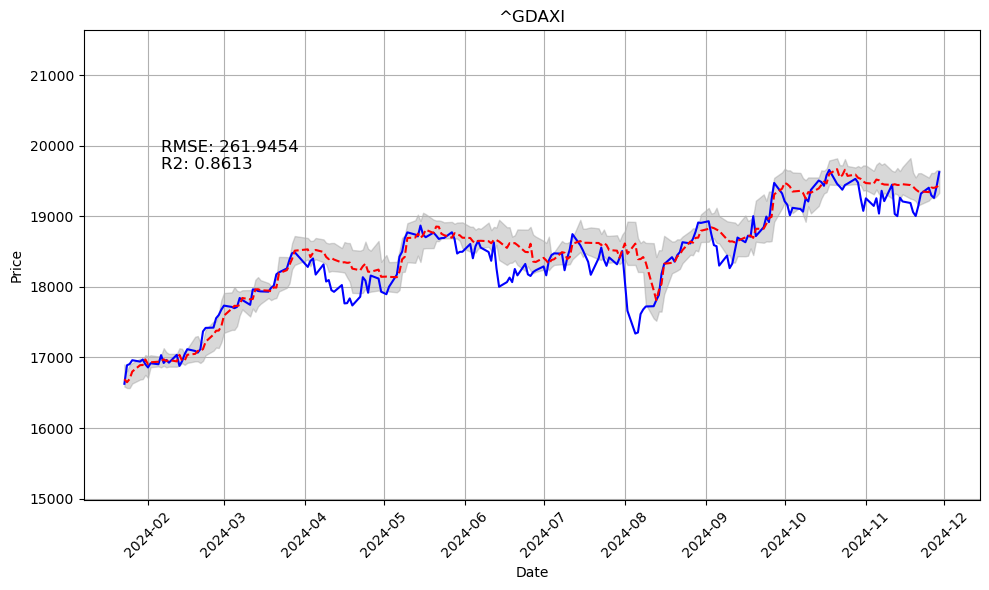

^GDAXI :
Root Mean Squared Error (RMSE): 261.9454
Out-of-Sample R2: 0.8613
Chart saved to Plots/CBU_predictions_chart.png (transparent background).


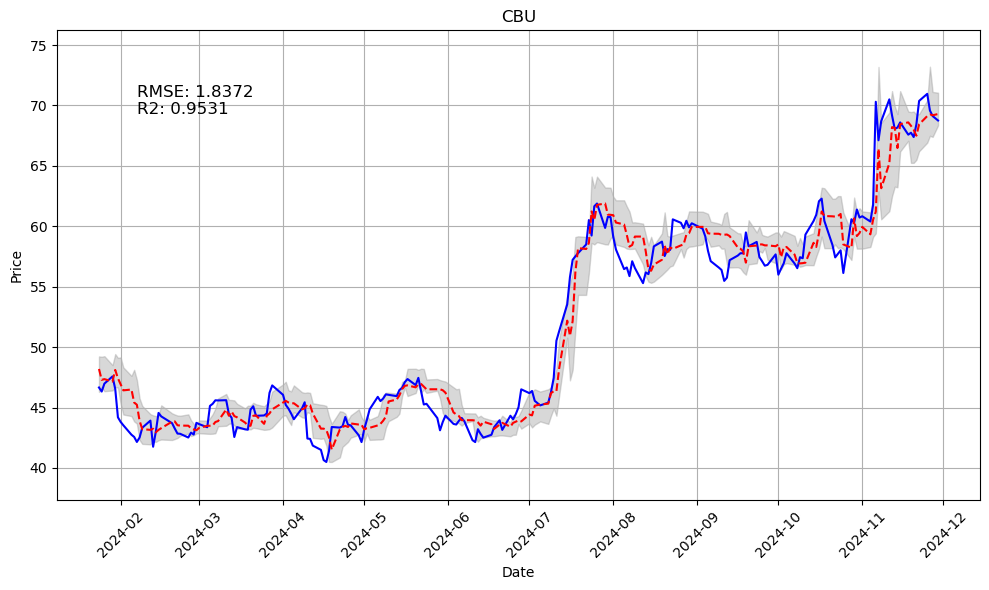

CBU :
Root Mean Squared Error (RMSE): 1.8372
Out-of-Sample R2: 0.9531
Chart saved to Plots/SnP500_predictions_chart.png (transparent background).


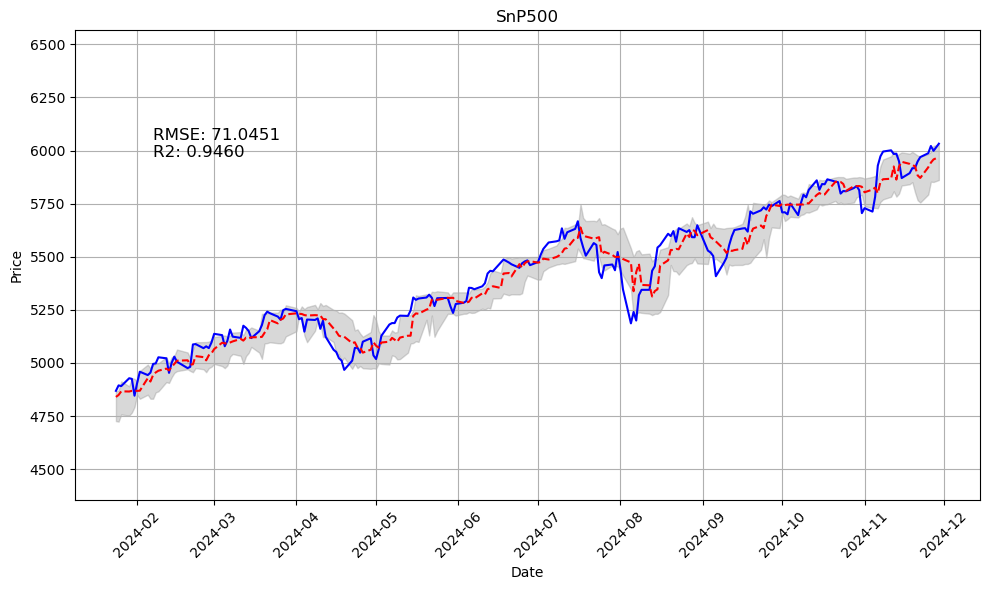

SnP500 :
Root Mean Squared Error (RMSE): 71.0451
Out-of-Sample R2: 0.9460
Chart saved to Plots/GOOG_predictions_chart.png (transparent background).


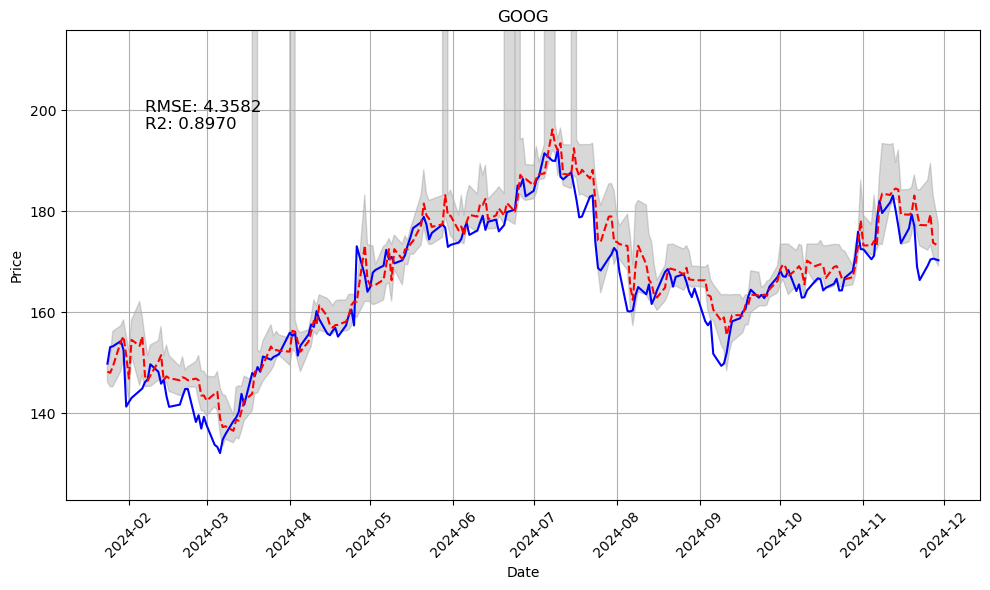

GOOG :
Root Mean Squared Error (RMSE): 4.3582
Out-of-Sample R2: 0.8970
Chart saved to Plots/XLE_predictions_chart.png (transparent background).


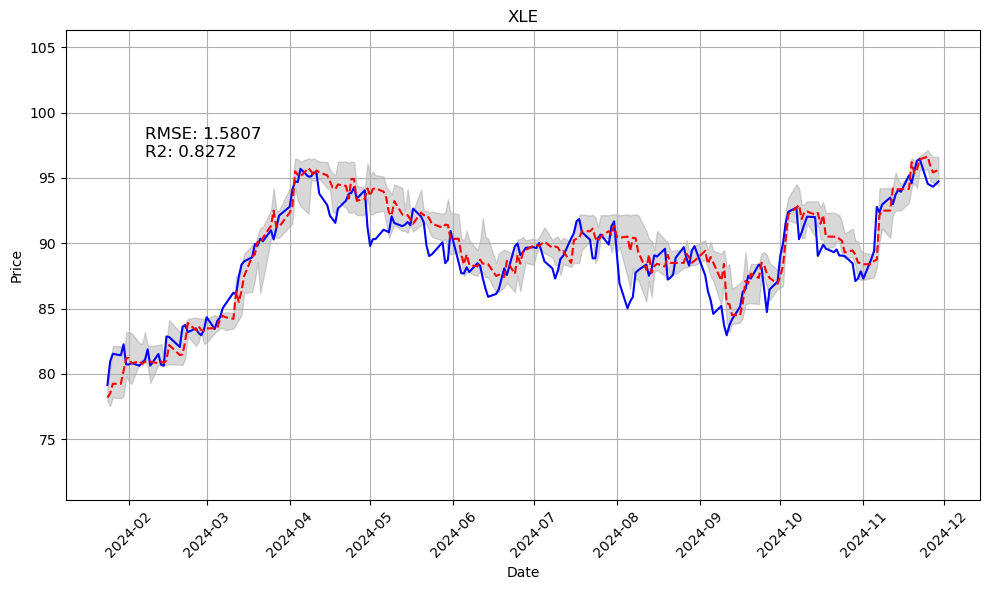

XLE :
Root Mean Squared Error (RMSE): 1.5807
Out-of-Sample R2: 0.8272
Chart saved to Plots/^STOXX_predictions_chart.png (transparent background).


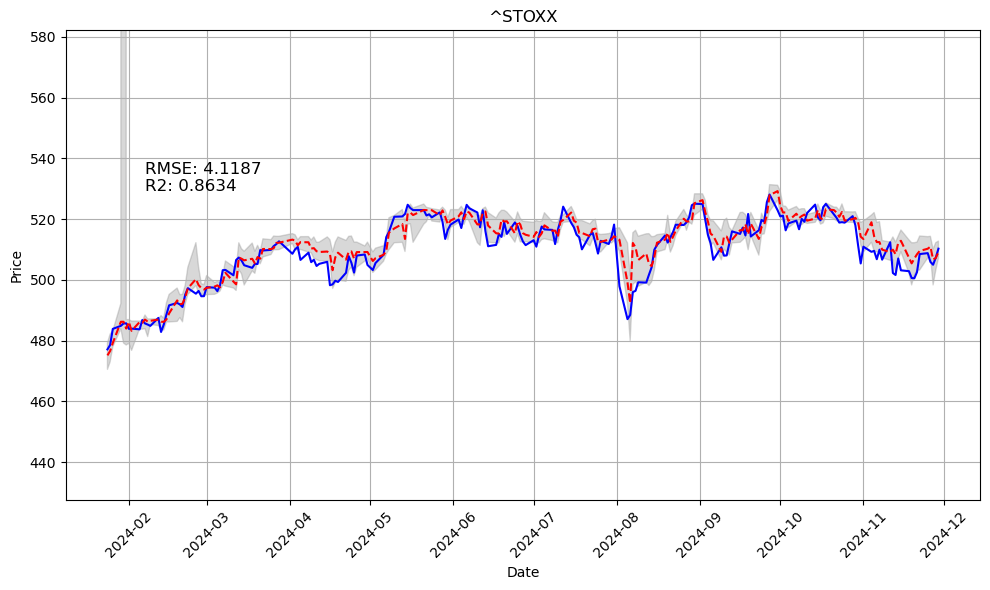

^STOXX :
Root Mean Squared Error (RMSE): 4.1187
Out-of-Sample R2: 0.8634
Chart saved to Plots/BTC-USD_predictions_chart.png (transparent background).


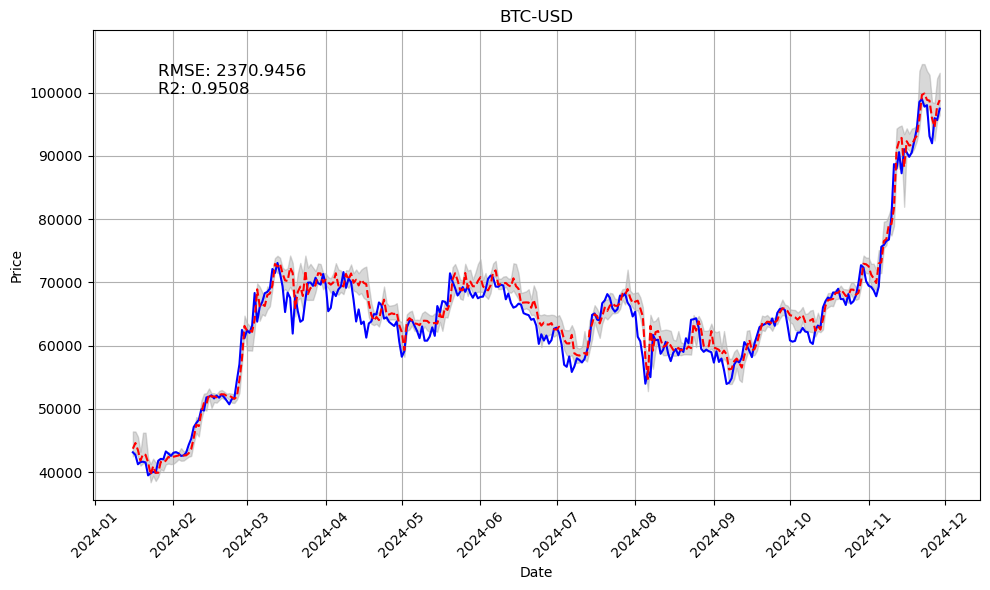

BTC-USD :
Root Mean Squared Error (RMSE): 2370.9456
Out-of-Sample R2: 0.9508
Chart saved to Plots/^N225_predictions_chart.png (transparent background).


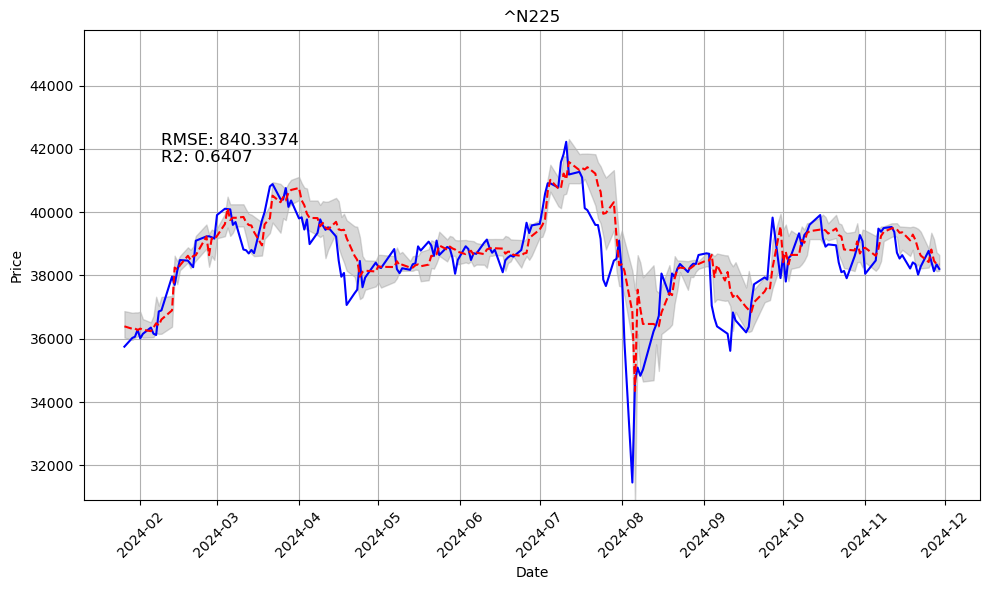

^N225 :
Root Mean Squared Error (RMSE): 840.3374
Out-of-Sample R2: 0.6407
Chart saved to Plots/^BSESN_predictions_chart.png (transparent background).


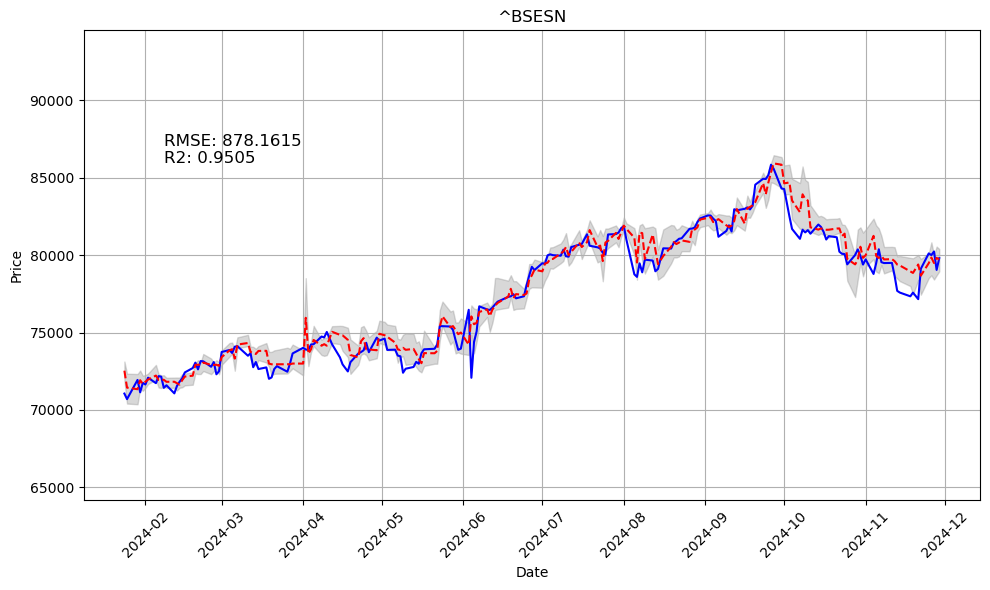

^BSESN :
Root Mean Squared Error (RMSE): 878.1615
Out-of-Sample R2: 0.9505
Chart saved to Plots/^FTSE_predictions_chart.png (transparent background).


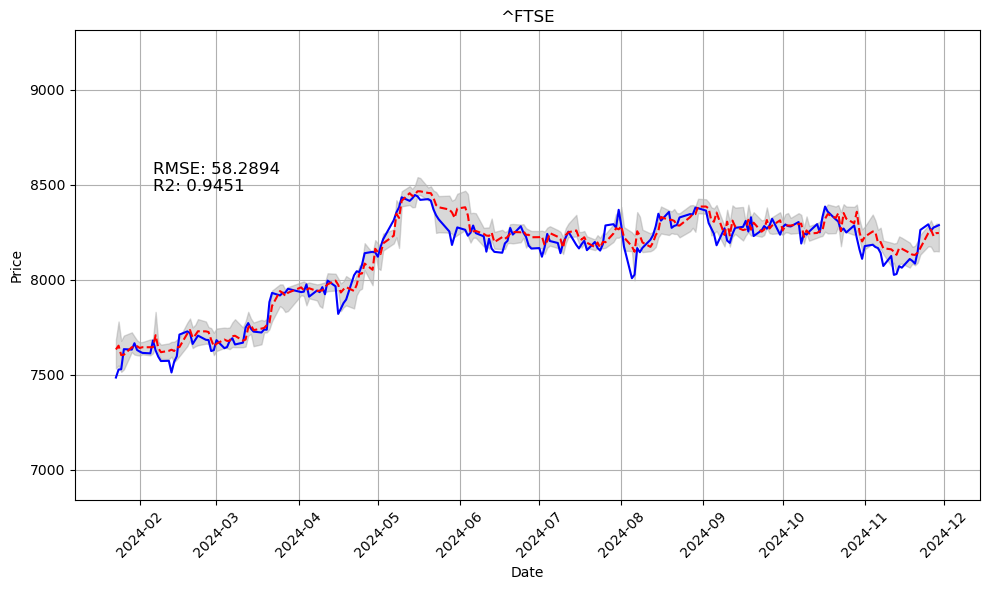

^FTSE :
Root Mean Squared Error (RMSE): 58.2894
Out-of-Sample R2: 0.9451


In [69]:
ticker_list = []
rmse_list = []
r2_list = []
min_list = []
max_list = []
scaled_rmse_list = []

files = [file for file in os.listdir() if ".csv" in file and "predictions_full" in file]

for file in files:
    data_df = pd.read_csv(file)
    ticker = file.split('_')[0]
    rmse, r2, minimum, maximum, scaled_rmse = plot_predictions_and_compute_metrics_probabilistic(asset_symbol = ticker,
                                                                                                 actual_price = data_df["Actual_Price"],
                                                                                                 predicted_price = data_df["Median_Prediction"],
                                                                                                 date_index_list = data_df["Date"],
                                                                                                 high = data_df["High_Prediction"],
                                                                                                 low =data_df["Low_Prediction"],
                                                                                                 probabilistic = True,
                                                                                                 save_path=f"Plots/{ticker}_predictions_chart.png")
    ticker_list.append(ticker)
    rmse_list.append(rmse)
    r2_list.append(r2)
    min_list.append(minimum)
    max_list.append(maximum)
    scaled_rmse_list.append(scaled_rmse)
    
result_dict = {'Ticker':ticker_list, 'RMSE':rmse_list, 'R2':r2_list, 'Min':min_list, 'Max':max_list, 'Scaled_RMSE':scaled_rmse_list}
result_df = pd.DataFrame(result_dict)
result_df.to_csv('LLM_Results.csv')

# Computing classification scores

In [90]:
def compute_classification_scores(y_actual, y_pred):
    accuracy = accuracy_score(y_actual, y_pred)
    precision = precision_score(y_actual, y_pred)
    recall = recall_score(y_actual, y_pred)
    f1 = f1_score(y_actual, y_pred)
    
    cm = confusion_matrix(y_actual, y_pred)
    plt.figure(figsize=(10, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()
    
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    
    return accuracy, precision, recall, f1, cm

### LLM predicted price movement evaluation






 ^GDAXI :


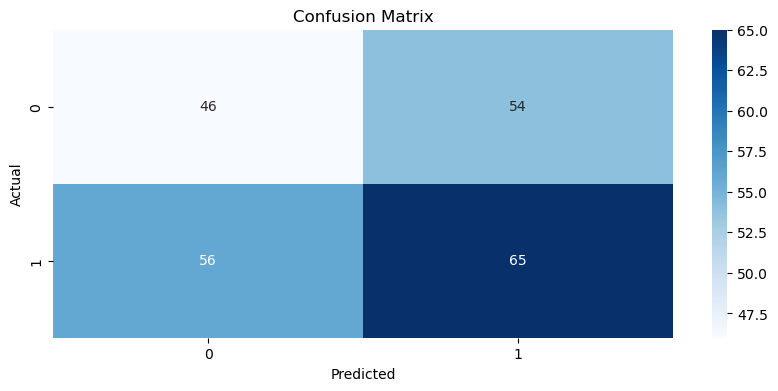

Accuracy: 0.5023
Precision: 0.5462
Recall: 0.5372
F1 Score: 0.5417





 CBU :


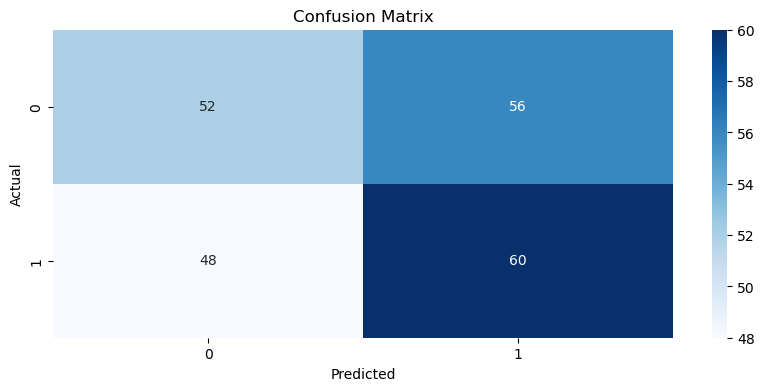

Accuracy: 0.5185
Precision: 0.5172
Recall: 0.5556
F1 Score: 0.5357





 SnP500 :


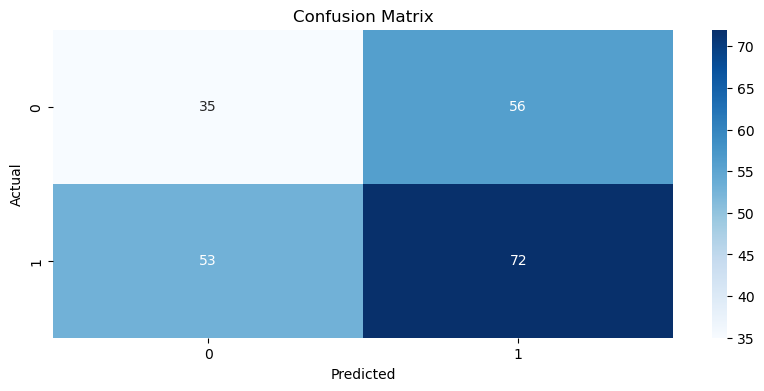

Accuracy: 0.4954
Precision: 0.5625
Recall: 0.5760
F1 Score: 0.5692





 GOOG :


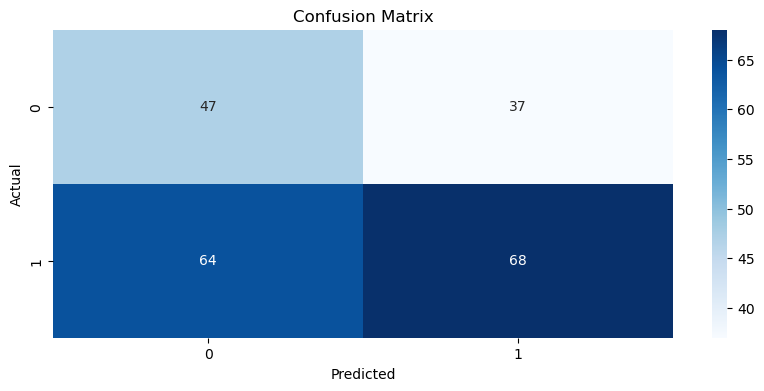

Accuracy: 0.5324
Precision: 0.6476
Recall: 0.5152
F1 Score: 0.5738





 XLE :


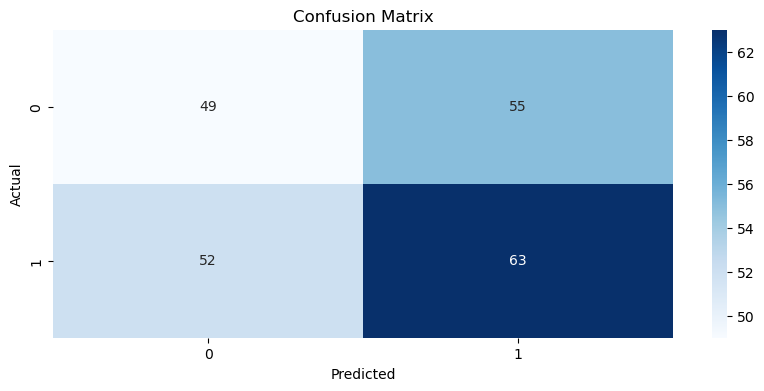

Accuracy: 0.5114
Precision: 0.5339
Recall: 0.5478
F1 Score: 0.5408





 ^STOXX :


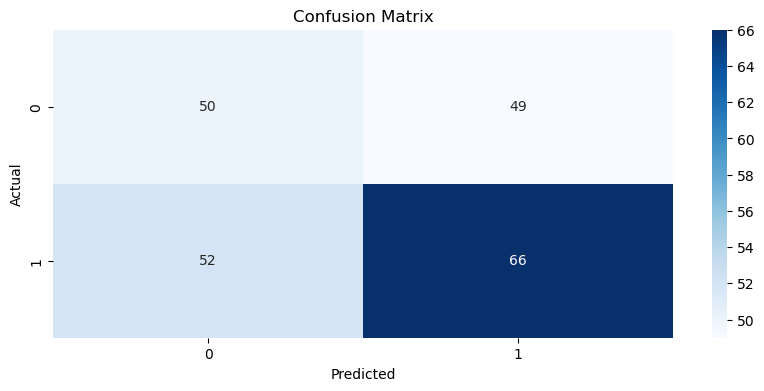

Accuracy: 0.5346
Precision: 0.5739
Recall: 0.5593
F1 Score: 0.5665





 BTC-USD :


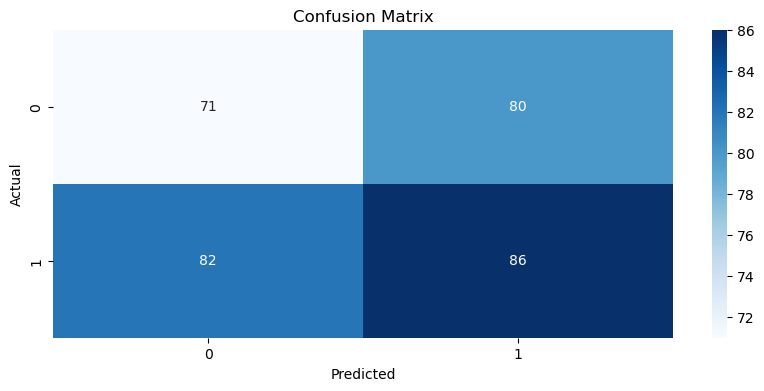

Accuracy: 0.4922
Precision: 0.5181
Recall: 0.5119
F1 Score: 0.5150





 ^N225 :


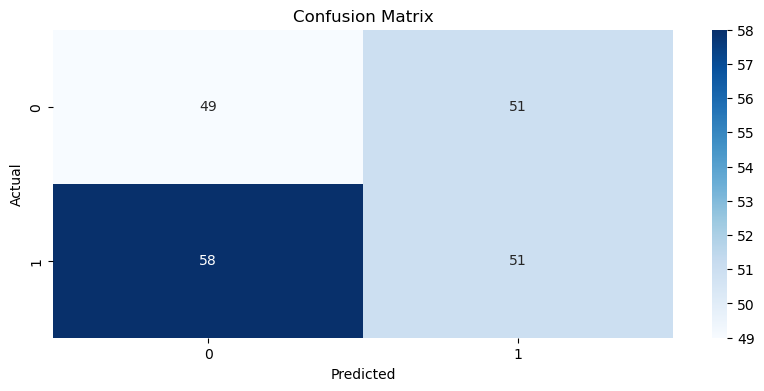

Accuracy: 0.4785
Precision: 0.5000
Recall: 0.4679
F1 Score: 0.4834





 ^BSESN :


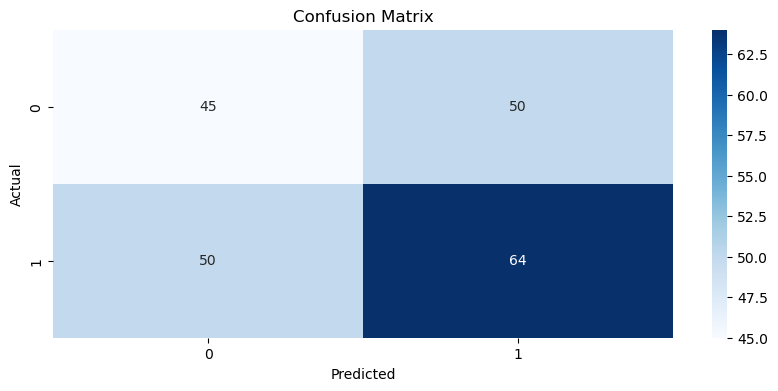

Accuracy: 0.5215
Precision: 0.5614
Recall: 0.5614
F1 Score: 0.5614





 ^FTSE :


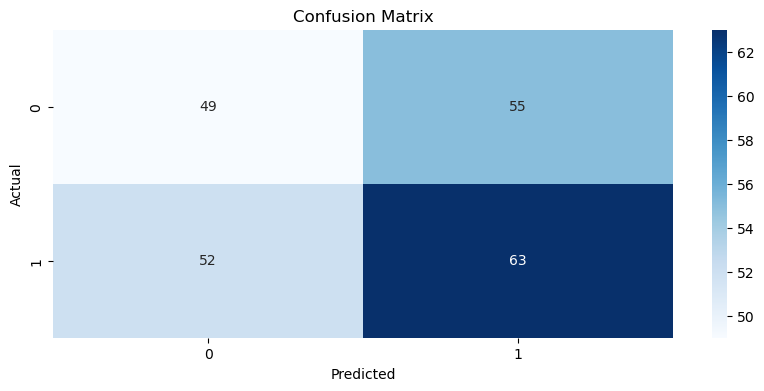

Accuracy: 0.5114
Precision: 0.5339
Recall: 0.5478
F1 Score: 0.5408


In [92]:
files = [file for file in os.listdir() if ".csv" in file and "predictions_full" in file]
results = []

for file in files:
    data_df = pd.read_csv(file)
    ticker = file.split('_')[0]
    print('\n\n\n\n\n',ticker,':')
    actual_movement = (data_df["Actual_Price"].diff()>=0)*1
    LLM_pred_movement = (data_df["Median_Prediction"].diff()>=0)*1
    accuracy, precision, recall, f1, cm = compute_classification_scores(actual_movement, LLM_pred_movement)
    results.append([ticker, accuracy, precision, recall, f1])
    
results_df = pd.DataFrame(results, columns=["Ticker", "Accuracy", "Precision", "Recall", "F1_score"])
results_df.to_csv("LLM_direction_prediction_eval.csv")

### Past as prediction for price movement evaluation






 ^GDAXI :


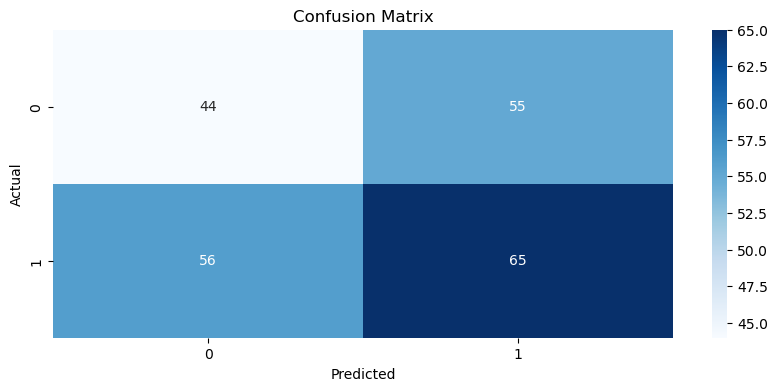

Accuracy: 0.4955
Precision: 0.5417
Recall: 0.5372
F1 Score: 0.5394





 CBU :


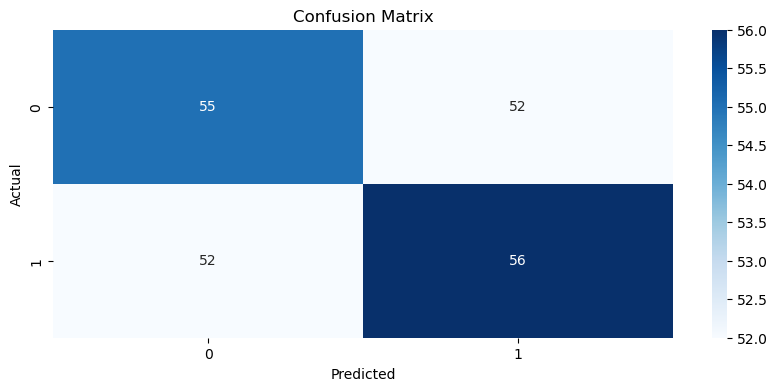

Accuracy: 0.5163
Precision: 0.5185
Recall: 0.5185
F1 Score: 0.5185





 SnP500 :


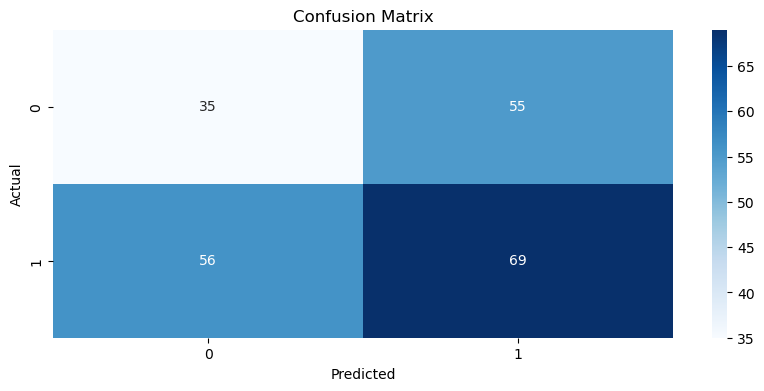

Accuracy: 0.4837
Precision: 0.5565
Recall: 0.5520
F1 Score: 0.5542





 GOOG :


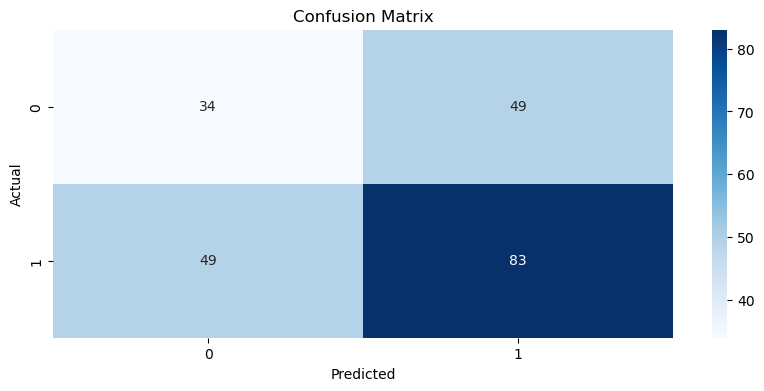

Accuracy: 0.5442
Precision: 0.6288
Recall: 0.6288
F1 Score: 0.6288





 XLE :


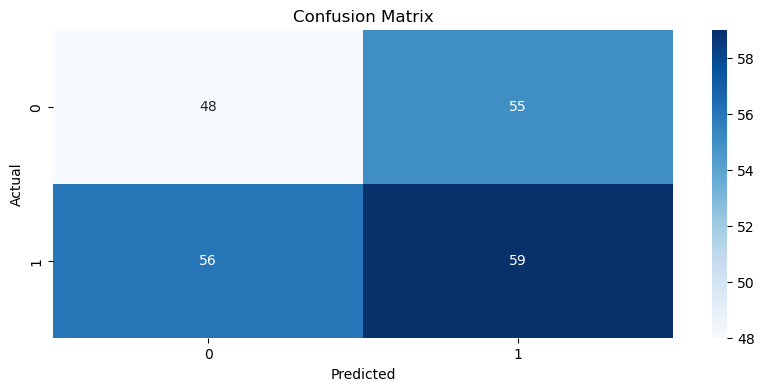

Accuracy: 0.4908
Precision: 0.5175
Recall: 0.5130
F1 Score: 0.5153





 ^STOXX :


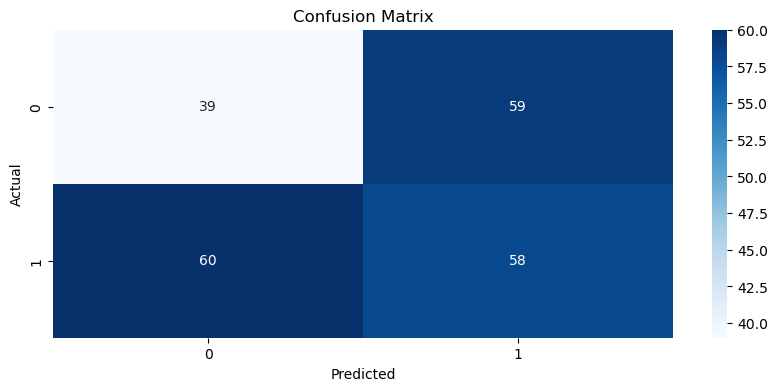

Accuracy: 0.4491
Precision: 0.4957
Recall: 0.4915
F1 Score: 0.4936





 BTC-USD :


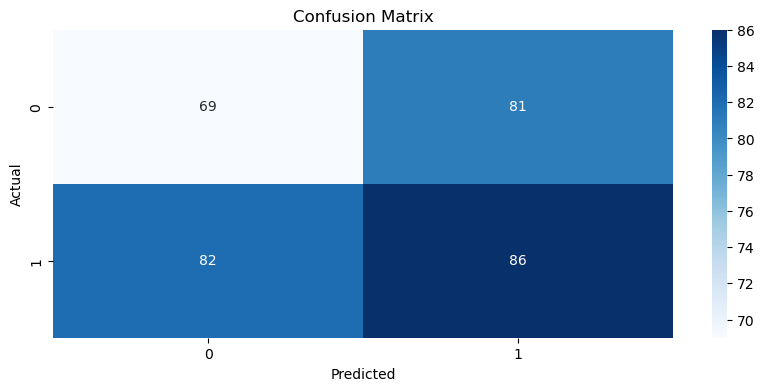

Accuracy: 0.4874
Precision: 0.5150
Recall: 0.5119
F1 Score: 0.5134





 ^N225 :


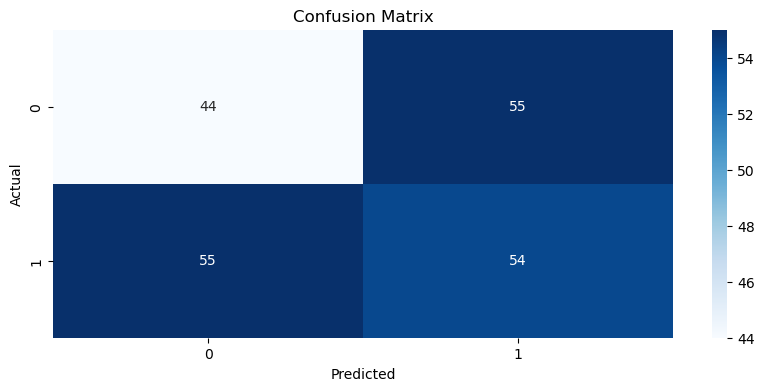

Accuracy: 0.4712
Precision: 0.4954
Recall: 0.4954
F1 Score: 0.4954





 ^BSESN :


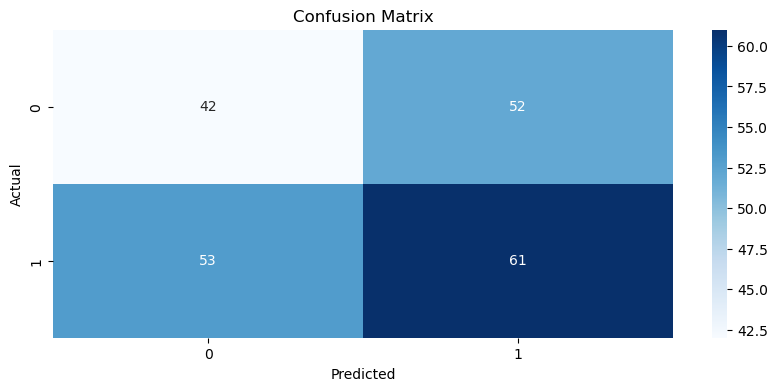

Accuracy: 0.4952
Precision: 0.5398
Recall: 0.5351
F1 Score: 0.5374





 ^FTSE :


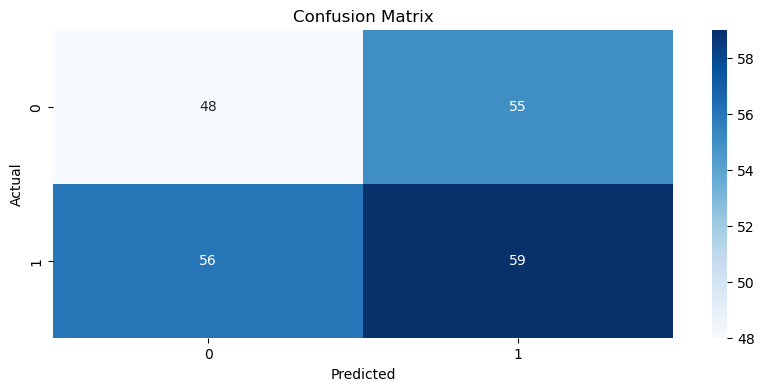

Accuracy: 0.4908
Precision: 0.5175
Recall: 0.5130
F1 Score: 0.5153


In [94]:
files = [file for file in os.listdir() if ".csv" in file and "predictions_full" in file]
results = []

for file in files:
    data_df = pd.read_csv(file)
    ticker = file.split('_')[0]
    print('\n\n\n\n\n',ticker,':')
    actual_movement = ((data_df["Actual_Price"].diff()>=0)*1)[1:].values
    prev_pred_movement = ((data_df["Actual_Price"].diff()>=0)*1)[:-1].values
    accuracy, precision, recall, f1, cm = compute_classification_scores(actual_movement, prev_pred_movement)
    results.append([ticker, accuracy, precision, recall, f1])
    
results_df = pd.DataFrame(results, columns=["Ticker", "Accuracy", "Precision", "Recall", "F1_score"])
results_df.to_csv("pastPred_direction_prediction_eval.csv")

In [129]:
### Testing
# actual_movement = ((data_df["Actual_Price"].diff()>=0)*1)[:-1].values
# LLM_pred_movement = ((data_df["Median_Prediction"].diff()>=0)*1)[1:].values

## Creating GIF from predictions

In [41]:
files = [file for file in os.listdir() if ".csv" in file and "predictions_full" in file]
print(files)
data_df = pd.read_csv(files[0])

data_df.columns

['^GDAXI_predictions_full.csv', 'CBU_predictions_full.csv', 'SnP500_predictions_full.csv', 'GOOG_predictions_full.csv', '^STOXX_predictions_full.csv', 'BTC-USD_predictions_full.csv', '^N225_predictions_full.csv', '^BSESN_predictions_full.csv', '^FTSE_predictions_full.csv']


Index(['Unnamed: 0', 'Date', 'Low_Prediction', 'Median_Prediction',
       'High_Prediction', 'Actual_Price'],
      dtype='object')

01/13/2025 11:17:41 PM - MovieWriter ffmpeg unavailable; using Pillow instead.
01/13/2025 11:17:41 PM - Animation.save using <class 'matplotlib.animation.PillowWriter'>
01/13/2025 11:18:12 PM - MovieWriter ffmpeg unavailable; using Pillow instead.
01/13/2025 11:18:12 PM - Animation.save using <class 'matplotlib.animation.PillowWriter'>
01/13/2025 11:18:41 PM - MovieWriter ffmpeg unavailable; using Pillow instead.
01/13/2025 11:18:41 PM - Animation.save using <class 'matplotlib.animation.PillowWriter'>
01/13/2025 11:19:11 PM - MovieWriter ffmpeg unavailable; using Pillow instead.
01/13/2025 11:19:11 PM - Animation.save using <class 'matplotlib.animation.PillowWriter'>
01/13/2025 11:19:22 PM - MovieWriter ffmpeg unavailable; using Pillow instead.
01/13/2025 11:19:22 PM - Animation.save using <class 'matplotlib.animation.PillowWriter'>
01/13/2025 11:19:52 PM - MovieWriter ffmpeg unavailable; using Pillow instead.
01/13/2025 11:19:52 PM - Animation.save using <class 'matplotlib.animation.P

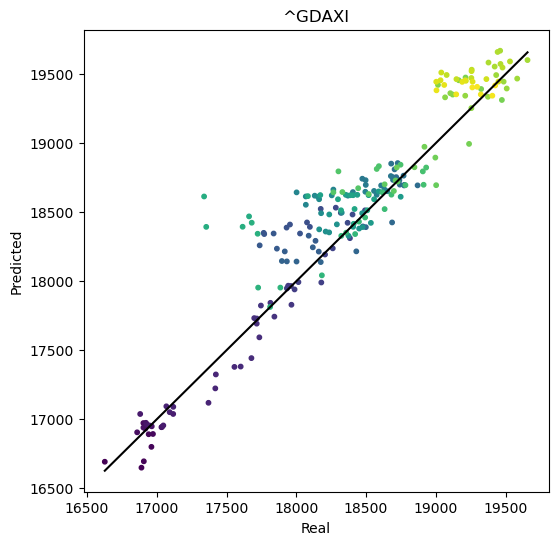

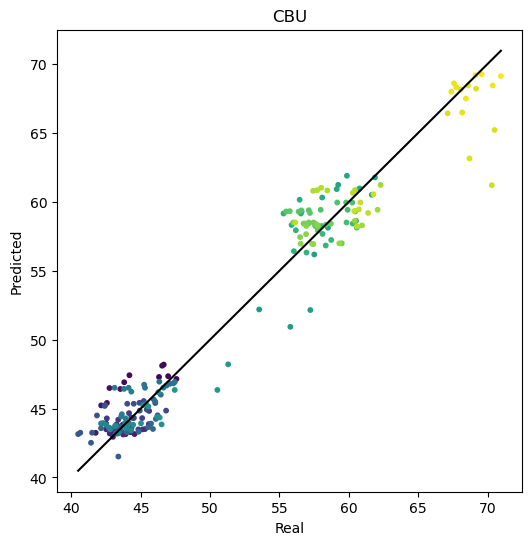

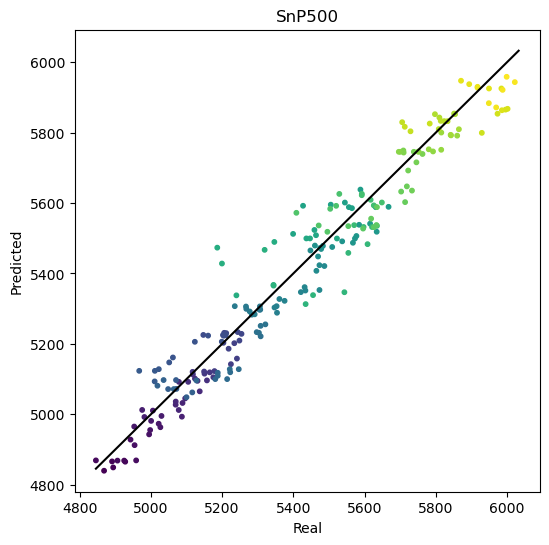

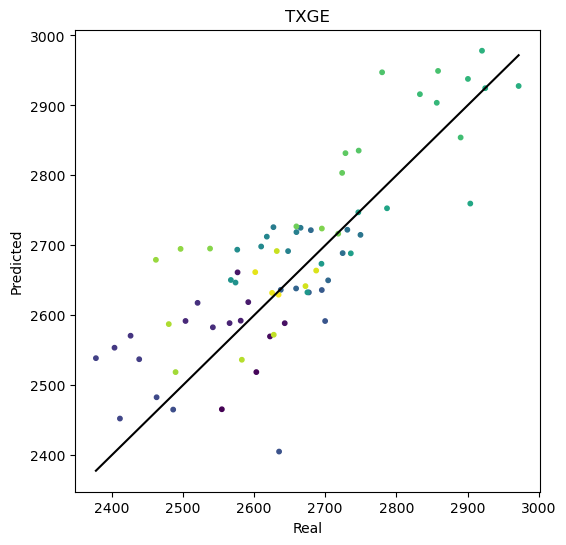

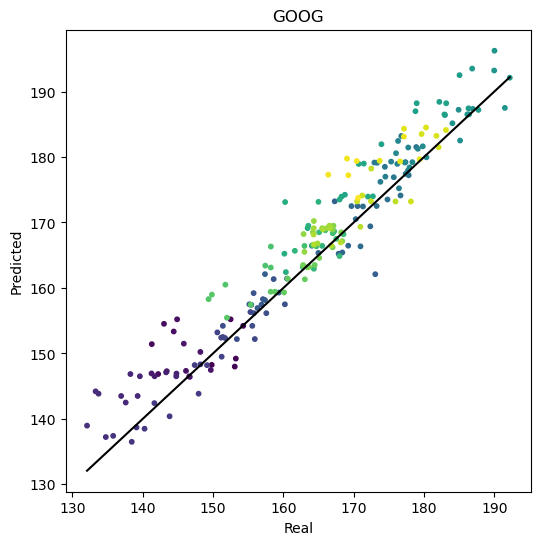

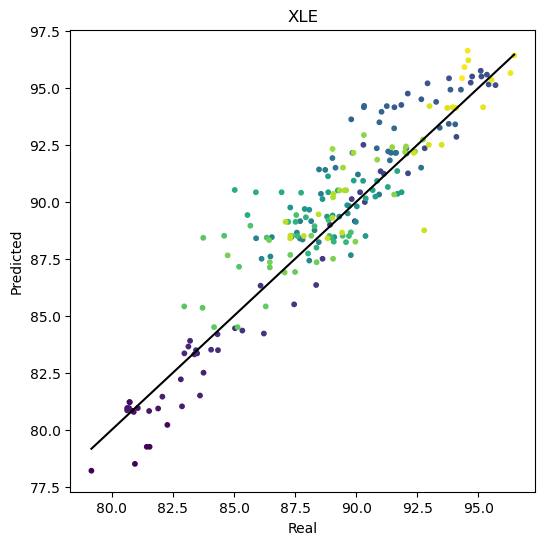

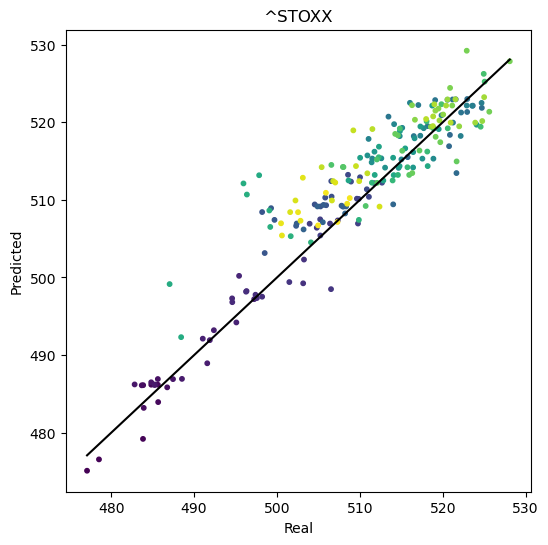

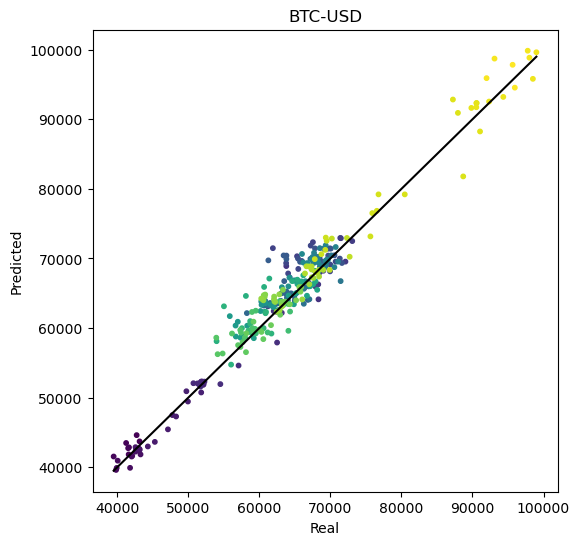

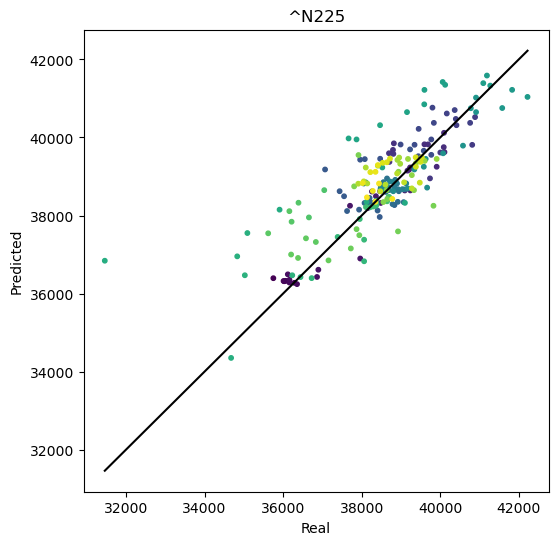

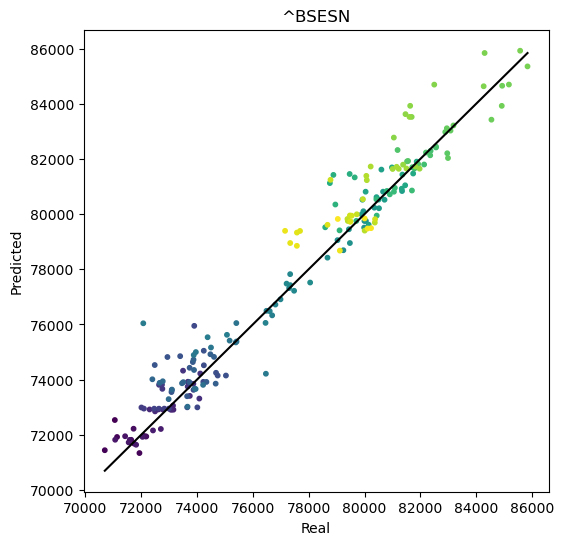

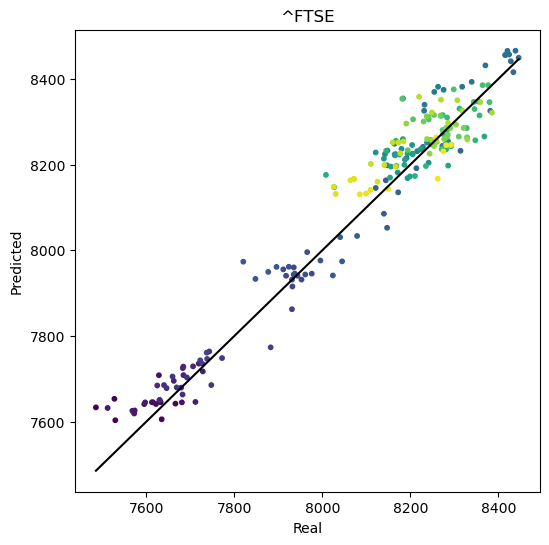

In [60]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from celluloid import Camera

files = [file for file in os.listdir() if ".csv" in file and "prediction" in file]
data_BTC = pd.read_csv("BTC-USD_predictions_full.csv")
data_BTC['Date'] = pd.to_datetime(data_BTC['Date'])


for file in files:
    ticker = file.split('_')[0]
    data_df = pd.read_csv(file)
    data_df['Date'] = pd.to_datetime(data_df['Date'])
    
    camera = Camera(plt.figure(figsize=(6,6)))
    for i in range(data_df.shape[0]):
        plt.plot([min(data_df['Actual_Price']), max(data_df['Actual_Price'])], [min(data_df['Actual_Price']), max(data_df['Actual_Price'])],
                 color='black')
        plt.xlabel("Real")
        plt.ylabel("Predicted")
        plt.title(ticker)
        plt.scatter(data_df['Actual_Price'][:i], data_df['Median_Prediction'][:i], c=np.arange(i),
                    cmap='viridis', s=10, vmin=0,
                    vmax=data_df.shape[0]-1)
        camera.snap()
    anim = camera.animate(blit=True)
    anim.save(f'RealVsPredicted_GIF/indipendent_legend/{ticker}_scatter.gif',dpi=220,fps=10)

In [62]:
from PIL import Image, ImageSequence
import numpy as np
import os

def remove_background_from_gif(input_gif_path, output_gif_path, bg_color=(255, 255, 255)):
    """
    Remove the background color from a GIF and save it as a new GIF file.

    Args:
        input_gif_path (str): Path to the input GIF file.
        output_gif_path (str): Path to save the output GIF file.
        bg_color (tuple): Background color to remove (R, G, B).
    """
    # Open the GIF
    with Image.open(input_gif_path) as gif:
        # Ensure the output directory exists
        os.makedirs(os.path.dirname(output_gif_path), exist_ok=True)

        # Process each frame of the GIF
        frames = []
        for frame in ImageSequence.Iterator(gif):
            frame = frame.convert("RGBA")  # Convert to RGBA for transparency handling
            np_frame = np.array(frame)    # Convert to numpy array for pixel manipulation
            print(np_frame.shape)
            
            # Find the background pixels and set alpha to 0
            red, green, blue, alpha = np_frame.T
            mask = (red == bg_color[0]) & (green == bg_color[1]) & (blue == bg_color[2])
            print(mask.shape)
            np_frame[..., -1][mask] = 0  # Set alpha to 0 for background pixels
            
            # Convert back to PIL image and append to frames
            processed_frame = Image.fromarray(np_frame, "RGBA")
            frames.append(processed_frame)

        # Save the processed frames as a new GIF
        frames[0].save(
            output_gif_path,
            save_all=True,
            append_images=frames[1:],
            loop=gif.info.get("loop", 0),
            duration=gif.info.get("duration", 100),
            transparency=0,
            disposal=2
        )
    print(f"Background removed GIF saved to {output_gif_path}")

# Usage example:
files = [file for file in os.listdir('RealVsPredicted_GIF/indipendent_legend') if ".gif" in file]
print(files)

for file in files:
    ticker = file.split('_')[0]
    input_gif = f'RealVsPredicted_GIF/indipendent_legend/{ticker}_scatter.gif'
    output_gif = f'RealVsPredicted_GIF/indipendent_legend/rem_BG/{ticker}_scatter_rmbg.gif'
    background_color = (255, 255, 255)  # White background
    remove_background_from_gif(input_gif, output_gif, background_color)

['TXGE_scatter.gif', '^GDAXI_scatter.gif', '^STOXX_scatter.gif', '^N225_scatter.gif', 'CBU_scatter.gif', 'GOOG_scatter.gif', '^FTSE_scatter.gif', 'BTC-USD_scatter.gif', 'SnP500_scatter.gif', 'XLE_scatter.gif', '^BSESN_scatter.gif']
(1320, 1320, 4)
(1320, 1320, 4)
(1320, 1320, 4)
(1320, 1320, 4)
(1320, 1320, 4)
(1320, 1320, 4)
(1320, 1320, 4)
(1320, 1320, 4)
(1320, 1320, 4)
(1320, 1320, 4)
(1320, 1320, 4)
(1320, 1320, 4)
(1320, 1320, 4)
(1320, 1320, 4)
(1320, 1320, 4)
(1320, 1320, 4)
(1320, 1320, 4)
(1320, 1320, 4)
(1320, 1320, 4)
(1320, 1320, 4)
(1320, 1320, 4)
(1320, 1320, 4)
(1320, 1320, 4)
(1320, 1320, 4)
(1320, 1320, 4)
(1320, 1320, 4)
(1320, 1320, 4)
(1320, 1320, 4)
(1320, 1320, 4)
(1320, 1320, 4)
(1320, 1320, 4)
(1320, 1320, 4)
(1320, 1320, 4)
(1320, 1320, 4)
(1320, 1320, 4)
(1320, 1320, 4)
(1320, 1320, 4)
(1320, 1320, 4)
(1320, 1320, 4)
(1320, 1320, 4)
(1320, 1320, 4)
(1320, 1320, 4)
(1320, 1320, 4)
(1320, 1320, 4)
(1320, 1320, 4)
(1320, 1320, 4)
(1320, 1320, 4)
(1320, 1320, 4)


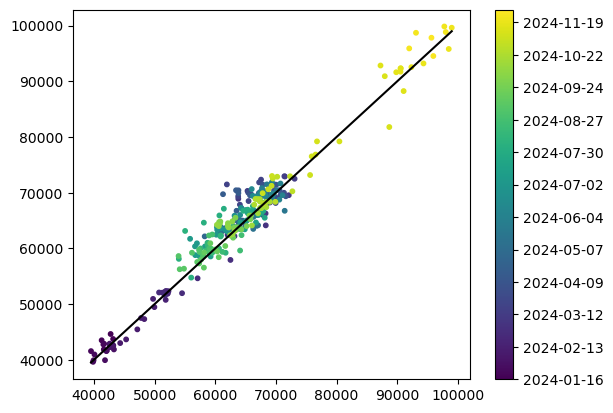

In [163]:
# Get Legend.
data_df = pd.read_csv(files[7])
data_df.columns

plt.plot([min(data_df['Actual_Price']), max(data_df['Actual_Price'])], [min(data_df['Actual_Price']), max(data_df['Actual_Price'])],
         color='black')
plt.scatter(data_df['Actual_Price'][:i], data_df['Median_Prediction'][:i], c=np.arange(i),
            cmap='viridis', s=10, vmin=0, vmax=data_df.shape[0])
cbar = plt.colorbar(ticks=np.arange(0,data_df.shape[0],5))
cbar.ax.set_yticklabels([data_df['Date'].astype(str)[i] for i in np.arange(0,data_df.shape[0],28)])  # [data_df['Date'].astype(str)[i] for i in np.arange(0,221,10)]
# cbar.ax.set_yticklabels(data_df['Date'][:i])
plt.savefig("Cbar_legend")
plt.show()